In [2]:
import os
import sys
sys.path.append('/mnt/weka/scratch/yang.liu3/pyworkspace/3DGS')

import json
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def draw_trajectory(transforms_path, ax, color='r', size=20):
    plt.style.use('seaborn-whitegrid')

    with open(transforms_path) as json_file:
        contents = json.load(json_file)
        fovx = contents["camera_angle_x"]
        frames = contents["frames"]
        pos_list = []

        for idx, frame in enumerate(frames):
            c2w = np.array(frame["rot_mat"])
            pos = c2w[:3, 3]  # camera center position
            pos_list.append(pos)
            x_dir = c2w[:3, 0] / (np.linalg.norm(c2w[:3, 0]) + 1e-8)
            y_dir = c2w[:3, 1] / (np.linalg.norm(c2w[:3, 1]) + 1e-8)
            z_dir = c2w[:3, 2] / (np.linalg.norm(c2w[:3, 2]) + 1e-8)
            a = pos + size * x_dir + size * y_dir + size * z_dir
            b = pos - size * x_dir + size * y_dir + size * z_dir
            c = pos - size * x_dir - size * y_dir + size * z_dir
            d = pos + size * x_dir - size * y_dir + size * z_dir

            dir = (a + b + c + d) / 4 - pos  # camera view direction, i.e. z-axis
            dir = dir / (np.linalg.norm(dir) + 1e-8)
            o = pos + dir * 3

            ax.plot([pos[0], o[0]], [pos[1], o[1]], color=color)
            ax.plot([pos[0], a[0]], [pos[1], a[1]], color=color)
            ax.plot([pos[0], b[0]], [pos[1], b[1]], color=color)
            ax.plot([pos[0], c[0]], [pos[1], c[1]], color=color)
            ax.plot([pos[0], d[0]], [pos[1], d[1]], color=color)
            ax.plot([a[0], b[0]], [a[1], b[1]], color=color)
            ax.plot([b[0], c[0]], [b[1], c[1]], color=color)
            ax.plot([c[0], d[0]], [c[1], d[1]], color=color)
            ax.plot([d[0], a[0]], [d[1], a[1]], color=color)

    ax.axis('equal')
    ax.set_xlabel('x/m')
    ax.set_ylabel('y/m')
    
    pos_list = np.array(pos_list)
    min_pos = np.min(pos_list, axis=0)
    max_pos = np.max(pos_list, axis=0)
    print('Min position: {}'.format(min_pos))
    print('Max position: {}'.format(max_pos))

Min position: [ -70. -710.  300.]
Max position: [  70. -550.  300.]
Min position: [-120. -760.  300.]
Max position: [ 120. -500.  300.]


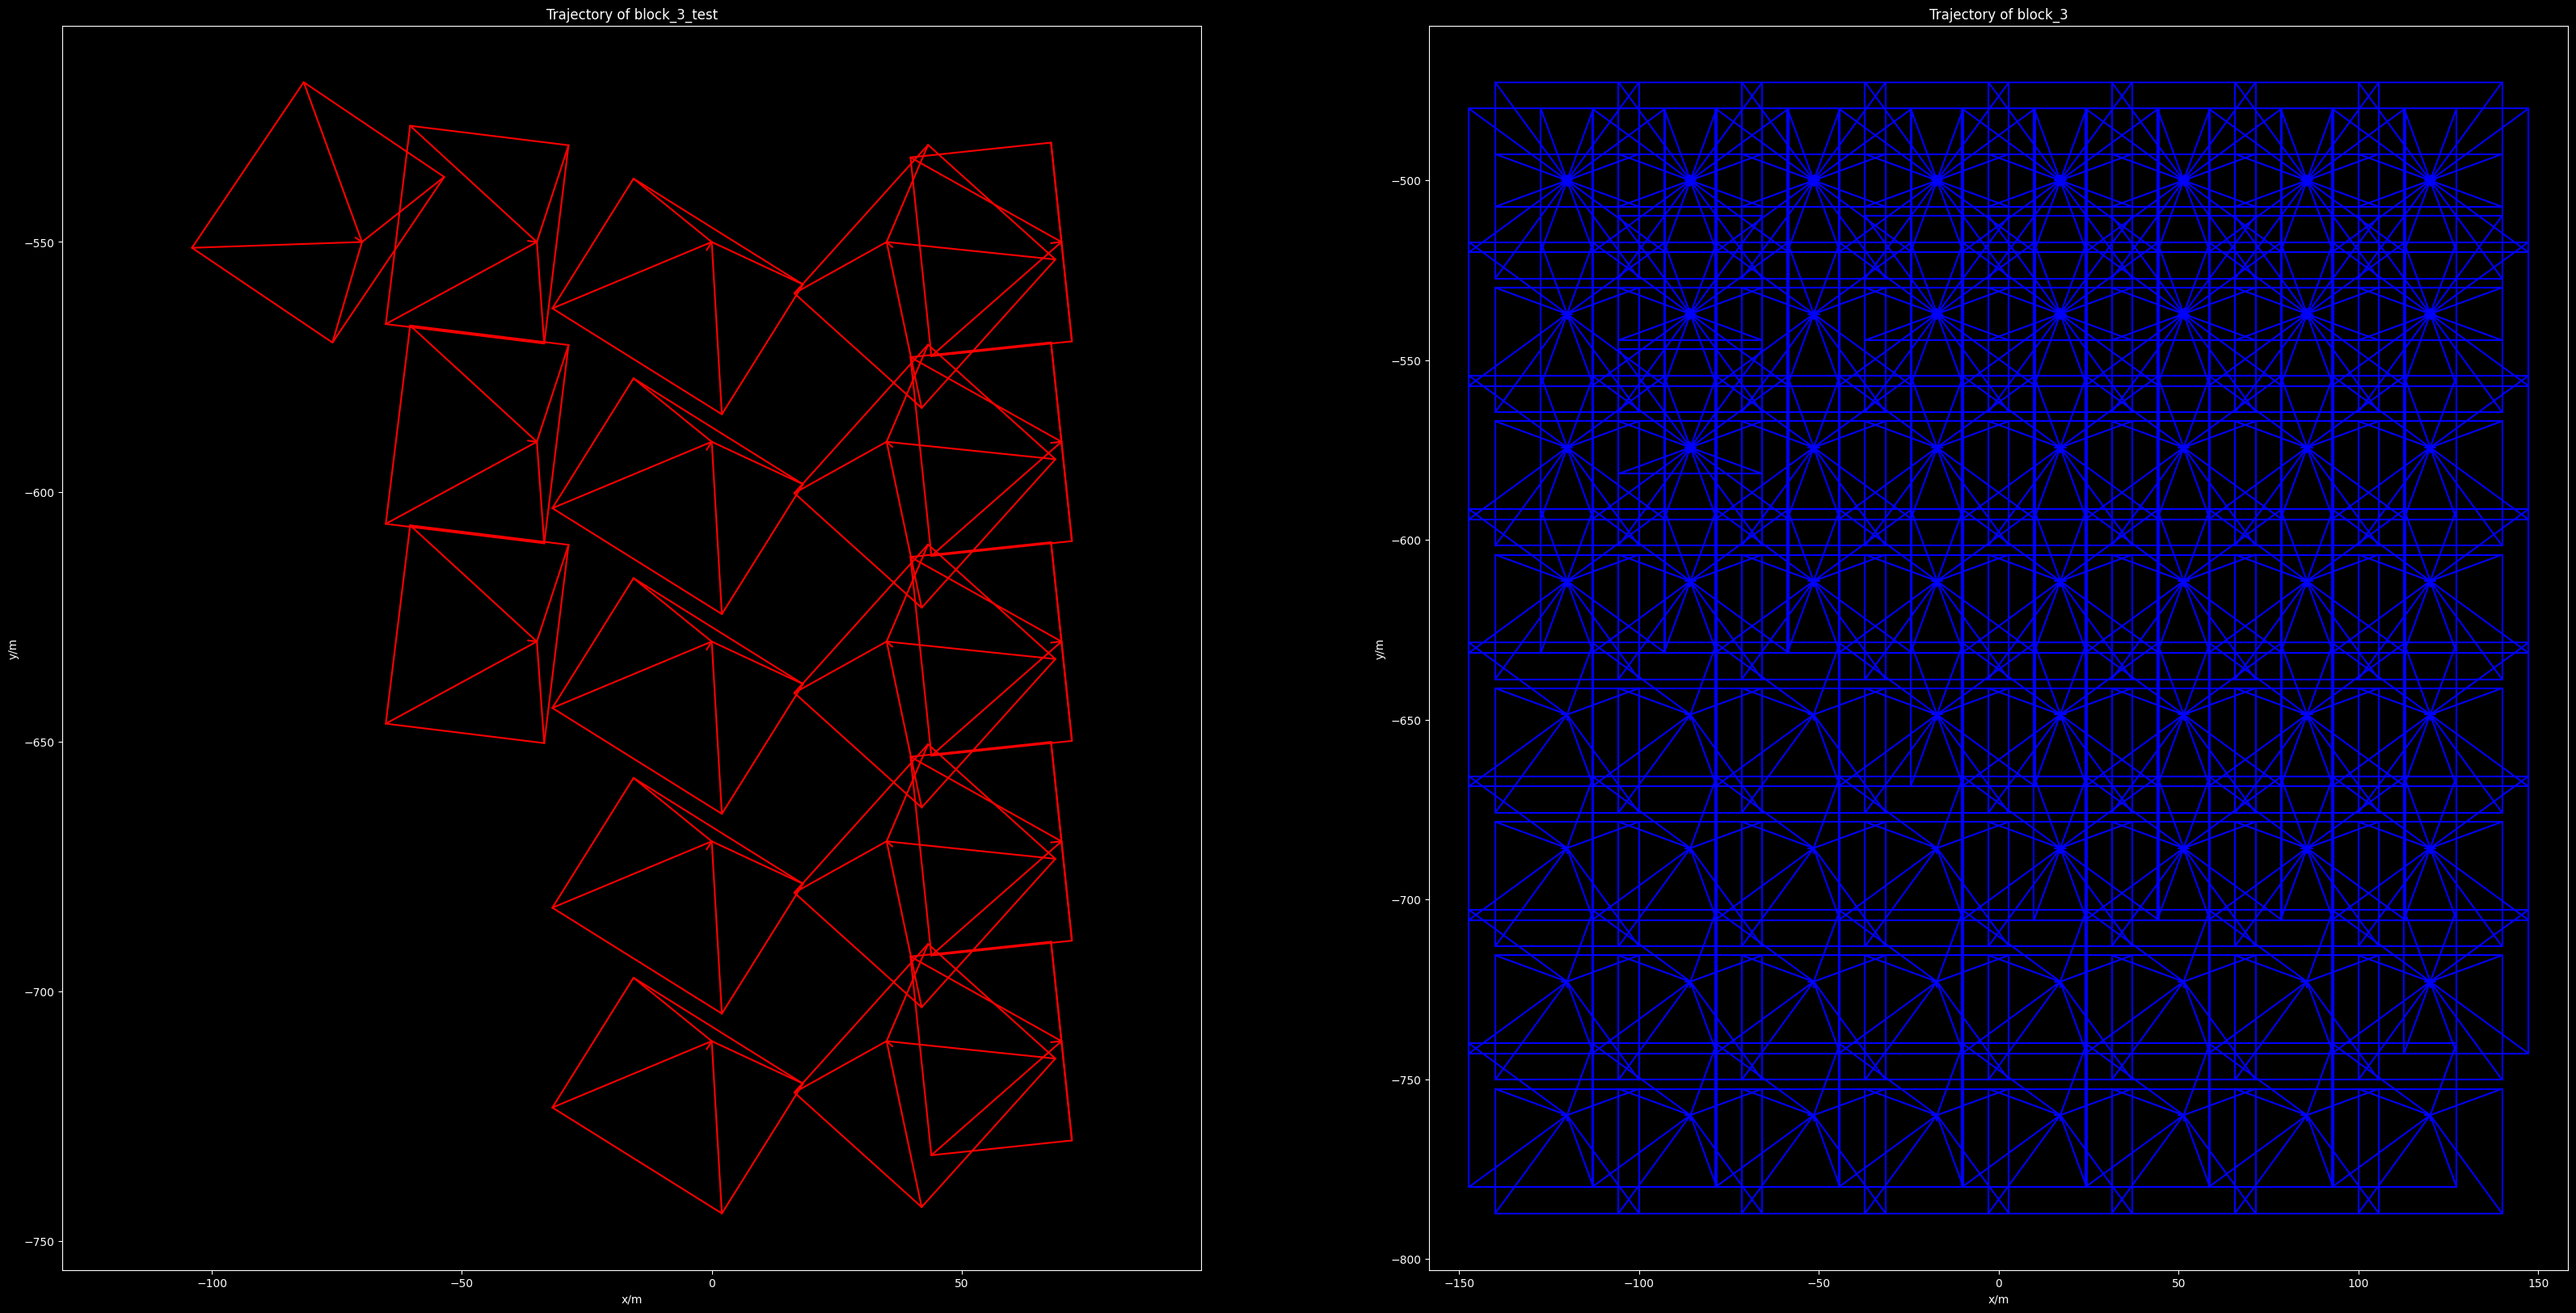

In [4]:
data_path, subset = '../data/matrix_city/aerial', 'block_3'
fig, axs = plt.subplots(1, 2, figsize=(40, 20))

split = 'test'
name = subset + '_test' if split == 'test' else subset
transforms_path = os.path.join(data_path, split, name, 'transforms.json')
axs[0].set_title(f'Trajectory of {name}')
draw_trajectory(transforms_path, axs[0], color='r', size=20)

split = 'train'
name = subset + '_test' if split == 'test' else subset
transforms_path = os.path.join(data_path, split, name, 'transforms.json')
axs[1].set_title(f'Trajectory of {name}')
draw_trajectory(transforms_path, axs[1], color='b', size=20)

plt.show()

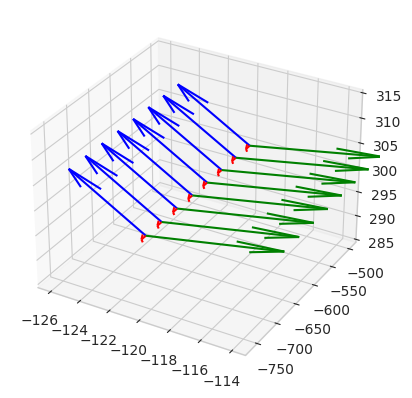

In [5]:
with open(transforms_path) as json_file:
    contents = json.load(json_file)

frames = contents["frames"]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, frame in enumerate(frames):
    if i == 8:
        break
    c2w = np.array(frame["rot_mat"])
    pos = c2w[:3, 3]
    x_dir = c2w[:3, 0] / (np.linalg.norm(c2w[:3, 0]) + 1e-8)
    y_dir = c2w[:3, 1] / (np.linalg.norm(c2w[:3, 1]) + 1e-8)
    z_dir = c2w[:3, 2] / (np.linalg.norm(c2w[:3, 2]) + 1e-8)

    # o_dir =(x_dir + y_dir + z_dir) / 3
    o_dir = z_dir

    ax.quiver(pos[0], pos[1], pos[2], x_dir[0], x_dir[1], x_dir[2], length=10, normalize=True, color='r')
    ax.quiver(pos[0], pos[1], pos[2], y_dir[0], y_dir[1], y_dir[2], length=10, normalize=True, color='g')
    ax.quiver(pos[0], pos[1], pos[2], z_dir[0], z_dir[1], z_dir[2], length=10, normalize=True, color='b')

plt.show()

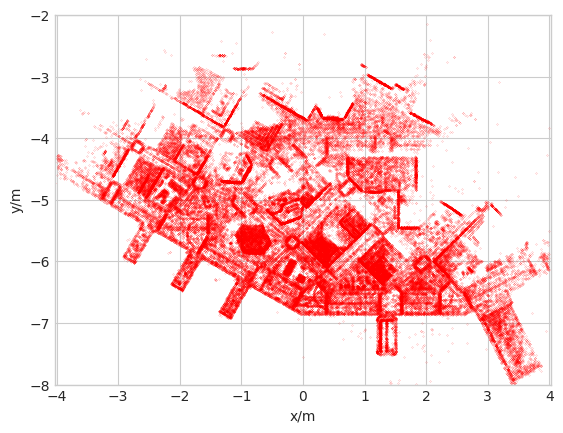

Min position: [-1.20000006 -7.6000002   3.00000001]
Max position: [ 1.20000006 -5.00000011  3.00000015]


In [7]:
from plyfile import PlyData, PlyElement
from scene.colmap_loader import read_extrinsics_binary, read_intrinsics_binary, qvec2rotmat

path = '../data/matrix_city/aerial/train/block_3'
cameras_extrinsic_file = os.path.join(path, "sparse/0", "images.bin")
cam_extrinsics = read_extrinsics_binary(cameras_extrinsic_file)
cameras_intrinsic_file = os.path.join(path, "sparse/0", "cameras.bin")
cam_intrinsics = read_intrinsics_binary(cameras_intrinsic_file)
ply_path = os.path.join(path, "sparse/0/points3D.ply")
plydata = PlyData.read(ply_path)
vertices = plydata['vertex']
positions = np.vstack([vertices['x'], vertices['y'], vertices['z']]).T

plt.style.use('seaborn-whitegrid')
fig = plt.figure()
plt.plot(positions[:, 0], positions[:, 1], 'ro', markersize=0.1)
plt.axis('equal')
plt.xlabel('x/m')
plt.ylabel('y/m')
plt.xlim([-4, 4])
plt.ylim([-8, -2])
plt.show()

# iterate on cam_extrinsics, note that it is a dict
list_pos = []
for key, extr in cam_extrinsics.items():
    # print(key, extr)
    R = np.transpose(qvec2rotmat(extr.qvec))
    T = np.array(extr.tvec)
    P = -R @ T
    list_pos.append(P)
    # plt.plot(P[0], P[1], 'ro', markersize=2)
    # print(key, ": ", P)
print('Min position: {}'.format(np.min(list_pos, axis=0)))
print('Max position: {}'.format(np.max(list_pos, axis=0)))
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()